In [9]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [10]:
PATH="/mnt/c/Users/KOJUNSUNG/Desktop/lab/kaggle/competitive-data-science-predict-future-sales/"
train = pd.read_csv(PATH + "sales_train.csv")
test = pd.read_csv(PATH + "test.csv")
shops = pd.read_csv(PATH + "shops.csv")
items = pd.read_csv(PATH + "items.csv")
category = pd.read_csv(PATH + "item_categories.csv")

In [11]:
# PATH="/kaggle/input/competitive-data-science-predict-future-sales/"
# train = pd.read_csv(PATH + "sales_train.csv")
# test = pd.read_csv(PATH + "test.csv")
# shop = pd.read_csv(PATH + "shops.csv")
# items = pd.read_csv(PATH + "items.csv")
# category = pd.read_csv(PATH + "item_categories.csv")

# 노트북 내내 진행되는 간단한 유틸 기능들
A few utility functions used throughout the notebook.

In [100]:
# 다운캐스팅은 부모 클래스가 자식 클래스 객체로 형변환 되는 것.

def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

# EDA

In [13]:
print(train.head(10))
print("=="*10)
print(test.head(10))

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
5   5        5     5039
6   6        5    

In [14]:
items.head(5)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [15]:
print("=="*10)
print(shops.head(10))
print("=="*10)
print(category.head(10))

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
5          Вологда ТРЦ "Мармелад"        5
6      Воронеж (Плехановская, 13)        6
7          Воронеж ТРЦ "Максимир"        7
8    Воронеж ТРЦ Сити-Парк "Град"        8
9               Выездная Торговля        9
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
5      Аксессуары - PSVita                 5
6    Аксессуары - XBOX 360                 6
7    Аксессуары - XBOX ONE                 7
8           Билеты (Цифра)                 8
9          Доставка товара                 9


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [17]:
print(train.isnull().sum())  #결측치는 없음
print("==="*10)
print(test.isna().sum())
print("==="*10)
print(items.isna().sum())
print("==="*10)
print(shops.isna().sum())
print("==="*10)
print(category.isna().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
ID         0
shop_id    0
item_id    0
dtype: int64
item_name           0
item_id             0
item_category_id    0
dtype: int64
shop_name    0
shop_id      0
dtype: int64
item_category_name    0
item_category_id      0
dtype: int64


In [18]:
shops.value_counts()

shop_name                                        shop_id
!Якутск Орджоникидзе, 56 фран                    0          1
!Якутск ТЦ "Центральный" фран                    1          1
Москва ТЦ "Серебряный Дом"                       32         1
Мытищи ТРК "XL-3"                                33         1
Н.Новгород ТРЦ "РИО"                             34         1
Н.Новгород ТРЦ "Фантастика"                      35         1
Новосибирск ТРЦ "Галерея Новосибирск"            36         1
Новосибирск ТЦ "Мега"                            37         1
Омск ТЦ "Мега"                                   38         1
РостовНаДону ТРК "Мегацентр Горизонт"            39         1
РостовНаДону ТРК "Мегацентр Горизонт" Островной  40         1
РостовНаДону ТЦ "Мега"                           41         1
СПб ТК "Невский Центр"                           42         1
СПб ТК "Сенная"                                  43         1
Самара ТЦ "Мелодия"                              44         1
Самара ТЦ "Па

# Data cleaning

훈련 DF 를 일반적인 데이터 정제 과정을 통해 정제함.

- datetime 연산을 할 수 있게 date feature 을 datetime 타입 객체로 변환

In [19]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

In [20]:
# shop의 중복 id 통합
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# test 셋에 남아있는 shop_id 만 사용
# 점수를 올리기 위한 일종의 과적합 테크닉
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
# training item의 극단적이거나 음수인 가격(또는 판매)값을 제거
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

In [21]:
# item_price, item_cnt_day 로그화하여 분포를 안정시킨 데이터
train["Log_item_price"] = np.log1p(train["item_price"])
train["Log_item_cnt_day"] = np.log1p(train["item_cnt_day"])

# Preprocessing

test data는 test month에 등록된 가격들로 shop 과 item의 모든 가능한 조합(데카르트 곱) 인 것으로 보입니다. 이것들의 목표 데이터는 각 shop-item 조합에 따른 총 월매출입니다. train 행렬(matrix)은 이런 구조들을 train 데이터 기간동안 똑같이 복제해 사용하는 형태입니다. feature들이 test 기간동안 만들어질 수 있도록, 테스트 item들은 training set에 마지막에 연결됩니다.   

In [22]:
# train 데이터를 test 데이터와 병합하여 새로운 train data 만들기.
# 점수를 올리기 위한 일종의 과적합 테크닉.

def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # sales_train 데이터에 revenue column 추가 
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # item_id / shop_id 에 따라 item_cnts 와 revenue 를 month level로 집계
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg( #월별, shopid별,itemid별 그룹바이
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"), #pandas.NamedAgg(column, aggfunc) 적용할 칼럼, 적용할 함수
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop("ID",1)

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # 혹시 있을지 모르는 달별 데이터의 na 데이터 0으로 대체
    df.item_cnt_month = df.item_cnt_month.fillna(0) 
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df


In [23]:
matrix = create_testlike_train(train, test)
del(test)

In [24]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month  item_revenue_month
0               0       59    22154             1.0               999.0
1               0       59     2552             0.0                 0.0
2               0       59     2554             0.0                 0.0
3               0       59     2555             0.0                 0.0
4               0       59     2564             0.0                 0.0

*** 'reduce_mem_usage' 기능은 데이터타입을 다운캐스트 하는데 이는 캐글 노트북 상에서 실행되는 중 메모리 오버플로우가 일어나지 않도록 하기 위해 필수적인 작업입니다. ***

In [25]:
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 405.44 MB
Memory usage after optimization is: 152.04 MB
Decreased by 62.5%


# Feature engineering

이 구간에서는 예측 정확성을 위해 임의의 feature 열들이 만들어지고 정렬 속에 추가됩니다.

# Item name groups with fuzzywuzzy
- item 테이블 내의 item 들은 필드 내에서 알파벳 순으로 정렬됩니다. 따라서 비슷한 아이템들은 일반적으로 근처에 배치됩니다. 예를 들어 한 개의 테이블 내의 최초의 두 개의 아이템들은 두 개의 다른 형태의 인터넷 보안을 사용하는 다른 콘솔을 사용한 같은 게임, 'Fuse'를 가리킵니다. 
- 이러한 정렬방식은 비슷한 종류의 아이템을 그룹핑하는데 도움이 됩니다.

In [26]:
items.query("item_id>3564").head(5)

item_name  item_id  \
3565                      Fuse [PS3, английская версия]     3565   
3566                 Fuse [Xbox 360, английская версия]     3566   
3567  G Data Internet Security 2013 (1ПК / 1 год) (G...     3567   
3568  G Data Internet Security 2013 (3ПК / 1 год) (G...     3568   
3569                      GABIN  The Best Of Gabin  2CD     3569   

      item_category_id  
3565                19  
3566                23  
3567                76  
3568                76  
3569                55

- 이하의 셀들은 비슷한 아이템들을 루프를 통해 연속적으로 묶는 과정입니다.
- string 타입의 데이터들을 이름의 비슷한 정도를 fuzzywuzzy 라이브러리를 사용하여 측정하고 일치값이 임계값을 초과하는 경우 같은 그룹으로 배정합니다.

In [27]:
!pip install fuzzywuzzy

In [28]:
import re #정규표현식 사용모듈

from fuzzywuzzy import fuzz # 문자열 일치에 사용되는 Python 라이브러리


def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string) # () 안의 문자 중 하나와 매치
            string = re.sub(r"\[.*?\]", "", string) # . = 모든 문자, *=반복, 앞의 문자 "." 이 가능한한 적게, 필요한한 계속 확장됨.
            return string  # item_name 안의 러시아어를 분리하기 위한 def

        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # 그룹 할당
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train


matrix, train = add_item_name_groups(matrix, train, items, 65)

In [29]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month  item_revenue_month  \
0               0       59    22154               1               999.0   
1               0       59     2552               0                 0.0   
2               0       59     2554               0                 0.0   
3               0       59     2555               0                 0.0   
4               0       59     2564               0                 0.0   

   item_name_group  
0             9737  
1             1085  
2             1086  
3             1087  
4             1092

In [30]:
matrix = reduce_mem_usage(matrix, silent=False)
gc.collect()

Memory usage of dataframe is 219.61 MB
Memory usage after optimization is: 168.93 MB
Decreased by 23.1%


388

# Music artist / first word of item name
- 이 기능은 music item 들을 item name 에서 3가지 일반적인 패턴(전부 대문자 형태, 제목 사이에 더블스페이스로 구분한 것, .으로 구분한 것)으로 추출한 artist name 에 따라 그룹으로 분류합니다. 

- non-music 카테고리들을 위해서는 대신해 아이템들을 첫번째 단어에 따라 분류합니다.

In [31]:
!pip install nltk

In [32]:
import nltk

In [33]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [34]:
from nltk.corpus import stopwords

In [35]:
def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
    #  이 기능은 음악 카테고리에 대한 아티스트 이름을 추출하여 특성으로 추가합니다.
    def extract_artist(st):
        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # 이중 공백 또는 모두 대문자 패턴을 사용하여 아티스트 이름을 검색합니다.
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # 가끔 패턴 중 하나가 쓸데없는 걸 추가로 잡아서, 제일 짧은 걸 선택하도록 합니다.
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # 이전 패턴 중 어느 것도 찾지 못한 경우 도트-스페이스 패턴을 사용합니다.
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    items = items.copy()
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    def first_word(string):
        # 이 함수는 특수 문자 문자열, 초과 공백 및 불용어를 정리한 다음 첫 번째 단어를 추출합니다.
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[
        items.item_category_id.isin(music_categories), "item_name"
    ].apply(extract_artist)
    items.loc[items[feature_name] == "", feature_name] = "other music"
    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[
        ~items.item_category_id.isin(music_categories), "item_name"
    ].apply(first_word)
    items.loc[items[feature_name] == "", feature_name] = "other non-music"
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    return matrix


matrix = add_first_word_features(
    matrix, items=items, feature_name="artist_name_or_first_word"
)

# 아이템 이름 길이를 특징(feature)으로 변환
- 아이템 이름 길이 특징은 매우 성능이 좋습니다. 아마도 비슷한 아이템들은 비슷한 이름 길이를 가지고 있기 때문일 것입니다. 
- 이 방법은 그냥 데이터와 정제된 데이터 모두에서 뛰어난 효과를 발휘했습니다. 이 방법은 항목간의 애매한 유사성들에 대한 정보를 포함하고 있습니다.

In [36]:
import re
def clean_item_name(string):
    # 괄호로 묶여있는 용어들 및 특수문자와 공백을 제거합니다.
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [37]:
print("Created name features")
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

Created name features


In [38]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month  item_revenue_month  \
0               0       59    22154               1               999.0   
1               0       59     2552               0                 0.0   
2               0       59     2554               0                 0.0   
3               0       59     2555               0                 0.0   
4               0       59     2564               0                 0.0   

   item_name_group  artist_name_or_first_word  item_name_length  \
0             9737                       4950                17   
1             1085                        384                40   
2             1086                        384                40   
3             1087                        384                39   
4             1092                        384                50   

   item_name_cleaned_length  
0                        13  
1                        38  
2                        38  
3                        32  
4                        43

In [39]:
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 219.61 MB
Memory usage after optimization is: 219.61 MB
Decreased by 0.0%


# Time features
- 일자와 월별 정확도(resolution) time feature 들은 training 데이터프레임에서 만들어졌습니다. 예를 들어 각 품목이 팔린 첫날과 마지막날 같은 데이터 말입니다.
- 각 항목의 첫번째 판매 이후의 시간은 sales-per-day 의 평균을 나타내는 feature(= ("item_cnt_day_avg") column)을 만드는데 사용됩니다. 
- 이 항목은 한 달이 지나기 전에 팔렸거나 해서 이전 달 전체 기간 내내 동안은 살 수 없었던 데이터들을 정정하는데 도움이 됩니다. 

In [40]:
def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # Sales tend to plateau after 12 months
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        return m

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )
    first_item_name_group_date = (
        train.groupby("item_name_group").date.min().rename("first_name_group_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )
    m = m.merge(
        first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
    )

    # 매달 상품이 얼마나 오래 진열되어있었는지 계산하고 이걸 일일 평균 상품판매량을 계산하는데 사용
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # 시작월로부터 시차를 계산하여 lag 없이 특성으로 사용될 수 있도록 처리
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)     # numpy.clip(array, min, max)  array 내의 element들에 대해서 min 값 보다 작은 값들을 min값으로 바꿔주고 max 값 보다 큰 값들을 max값으로 바꿔주는 함수
    m["first_item_sale_days"] = (
        m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_name_group_sale_days"] = (
        m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )

    # 마지막 판매로부터의 날짜 추가
    def last_sale_days(matrix):
        last_shop_item_dates = []
        for dbn in range(1, 35):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)

        last_shop_item_dates = pd.concat(last_shop_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval   # 차가 2000이 넘으면 결측치로 처리
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )

        matrix = matrix.drop(columns=["last_shop_item_sale_date"])
        return matrix

    m = last_sale_days(m)
    # 월 지표
    m["month"] = m["month_first_day"].dt.month
    # # 월 지표에 분기 지표 추가
    # m["quarter"] = m["month_first_day"].dt.quarter
    
    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length",
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    return m

In [41]:
gc.collect()
matrix = reduce_mem_usage(matrix, silent=False)

Memory usage of dataframe is 219.61 MB
Memory usage after optimization is: 219.61 MB
Decreased by 0.0%


In [42]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


In [43]:
matrix.head() # 절기 feature 추가해볼까?

date_block_num  shop_id  item_id  item_cnt_month  item_revenue_month  \
0               0       59    22154               1               999.0   
1               0       59     2552               0                 0.0   
2               0       59     2554               0                 0.0   
3               0       59     2555               0                 0.0   
4               0       59     2564               0                 0.0   

   item_name_group  artist_name_or_first_word  item_name_length  \
0             9737                       4950                17   
1             1085                        384                40   
2             1086                        384                40   
3             1087                        384                39   
4             1092                        384                50   

   item_name_cleaned_length  shop_open_days  item_cnt_day_avg  \
0                        13               0          0.033333   
1                        38               0          0.000000   
2                        38               0          0.000000   
3                        32               0          0.000000   
4                        43               0          0.000000   

   first_item_sale_days  first_shop_item_sale_days  \
0                  9999                     9999.0   
1                  9999                     9999.0   
2                  9999                     9999.0   
3                  9999                     9999.0   
4                  9999                     9999.0   

   first_name_group_sale_days  last_shop_item_sale_days  month  quarter  \
0                      9999.0                    9999.0      1        1   
1                      9999.0                    9999.0      1        1   
2                      9999.0                    9999.0      1        1   
3                      9999.0                    9999.0      1        1   
4                      9999.0                    9999.0      1        1   

   item_age  new_item  shop_age  
0         0         1         0  
1         0         1         0  
2         0         1         0  
3         0         1         0  
4         0         1         0

In [44]:
matrix = reduce_mem_usage(matrix, silent=False)

Memory usage of dataframe is 785.54 MB
Memory usage after optimization is: 380.10 MB
Decreased by 51.6%


# Price features
전달 팔린 item 들의 가격과 관련된 다른 아이템들의 가격들입니다. 

In [45]:
def add_price_features(matrix, train):
    # Get mean prices per month from train dataframe
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    return matrix

In [46]:
matrix = add_price_features(matrix, train)
del(train)

In [47]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month  item_revenue_month  \
0               0       59    22154               1               999.0   
1               0       59     2552               0                 0.0   
2               0       59     2554               0                 0.0   
3               0       59     2555               0                 0.0   
4               0       59     2564               0                 0.0   

   item_name_group  artist_name_or_first_word  item_name_length  \
0             9737                       4950                17   
1             1085                        384                40   
2             1086                        384                40   
3             1087                        384                39   
4             1092                        384                50   

   item_name_cleaned_length  shop_open_days  ...  first_shop_item_sale_days  \
0                        13               0  ...                       9999   
1                        38               0  ...                       9999   
2                        38               0  ...                       9999   
3                        32               0  ...                       9999   
4                        43               0  ...                       9999   

   first_name_group_sale_days  last_shop_item_sale_days  month  quarter  \
0                        9999                      9999      1        1   
1                        9999                      9999      1        1   
2                        9999                      9999      1        1   
3                        9999                      9999      1        1   
4                        9999                      9999      1        1   

   item_age  new_item  shop_age  last_item_price  last_norm_diff_cat_price  
0         0         1         0              NaN                       NaN  
1         0         1         0              NaN                       NaN  
2         0         1         0              NaN                       NaN  
3         0         1         0              NaN                       NaN  
4         0         1         0              NaN                       NaN  

[5 rows x 22 columns]

In [48]:
matrix['item_name_group'].value_counts()

1372    28427
643     25592
979     25416
6824    20453
6732    19341
        ...  
8936       35
9682       35
8252       35
8941       35
2060       35
Name: item_name_group, Length: 9500, dtype: int64

In [49]:
matrix.head().T

0       1       2       3       4
date_block_num                  0.000000     0.0     0.0     0.0     0.0
shop_id                        59.000000    59.0    59.0    59.0    59.0
item_id                     22154.000000  2552.0  2554.0  2555.0  2564.0
item_cnt_month                  1.000000     0.0     0.0     0.0     0.0
item_revenue_month            999.000000     0.0     0.0     0.0     0.0
item_name_group              9737.000000  1085.0  1086.0  1087.0  1092.0
artist_name_or_first_word    4950.000000   384.0   384.0   384.0   384.0
item_name_length               17.000000    40.0    40.0    39.0    50.0
item_name_cleaned_length       13.000000    38.0    38.0    32.0    43.0
shop_open_days                  0.000000     0.0     0.0     0.0     0.0
item_cnt_day_avg                0.033333     0.0     0.0     0.0     0.0
first_item_sale_days         9999.000000  9999.0  9999.0  9999.0  9999.0
first_shop_item_sale_days    9999.000000  9999.0  9999.0  9999.0  9999.0
first_name_group_sale_days   9999.000000  9999.0  9999.0  9999.0  9999.0
last_shop_item_sale_days     9999.000000  9999.0  9999.0  9999.0  9999.0
month                           1.000000     1.0     1.0     1.0     1.0
quarter                         1.000000     1.0     1.0     1.0     1.0
item_age                        0.000000     0.0     0.0     0.0     0.0
new_item                        1.000000     1.0     1.0     1.0     1.0
shop_age                        0.000000     0.0     0.0     0.0     0.0
last_item_price                      NaN     NaN     NaN     NaN     NaN
last_norm_diff_cat_price             NaN     NaN     NaN     NaN     NaN

In [50]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month  item_revenue_month  \
0               0       59    22154               1               999.0   
1               0       59     2552               0                 0.0   
2               0       59     2554               0                 0.0   
3               0       59     2555               0                 0.0   
4               0       59     2564               0                 0.0   

   item_name_group  artist_name_or_first_word  item_name_length  \
0             9737                       4950                17   
1             1085                        384                40   
2             1086                        384                40   
3             1087                        384                39   
4             1092                        384                50   

   item_name_cleaned_length  shop_open_days  ...  first_shop_item_sale_days  \
0                        13               0  ...                       9999   
1                        38               0  ...                       9999   
2                        38               0  ...                       9999   
3                        32               0  ...                       9999   
4                        43               0  ...                       9999   

   first_name_group_sale_days  last_shop_item_sale_days  month  quarter  \
0                        9999                      9999      1        1   
1                        9999                      9999      1        1   
2                        9999                      9999      1        1   
3                        9999                      9999      1        1   
4                        9999                      9999      1        1   

   item_age  new_item  shop_age  last_item_price  last_norm_diff_cat_price  
0         0         1         0              NaN                       NaN  
1         0         1         0              NaN                       NaN  
2         0         1         0              NaN                       NaN  
3         0         1         0              NaN                       NaN  
4         0         1         0              NaN                       NaN  

[5 rows x 22 columns]

# Item category features  
- 주어진 아이템 카테고리에 더해 두 개의 추가적인 카테고리 그룹을 더해줬습니다. 
- 상위 그룹(예: "games", "music")과 플랫폼(예:  "PS4", "mp3")

In [51]:
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8
}
matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

# Shop city
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

기존 문서가 참조한 다른 문서의 특성 값입니다.

항목의 설명을 보면 각각의 shop_name 이 각자의 도시 이름으로 시작하고 category 가 종류와 하위종류를 이름에 포함 중이라고 하는군요.
하단의 코드는 이 특성을 분리하고 저장하는 코드입니다. 

In [52]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)
del(shops)

# Shop and item 카테고리 군집화(category clustering)

- shop 과 item 카테고리들은 sales 상태에 따라 군집화되어 있습니다.
- 하단의 function 은 shop 과 item 카테고리들에 대해  주성분분석 분해 및 클러스터링(군집화)을 실시하고 그 결과를 그립니다. 

- 각 PCA 차원에 의해 설명되는 아이템 간의 설명 분산 비율이 표시되고 개별 아이템들이 PCA 차원의 점수에 따라 표시되고 군집그룹에 따라 색깔이 배정됩니다.

- 파라미터의 다양한 값에 대한 'The silhouette score' (군집화 수준 점수) 역시 표시됩니다. 이런 그림들은 군집화 정도(군집화 그룹 수)를 결정하는데 사용됩니다. 

- shop 과 item 카테고리들에 대해 발생하는 차이의 80% 이상이 단일차원에서 발생합니다. 이는 차이가 주로 비율보다는 크기에 의해 발생한다는 사실을 나타냅니다. 항목 구성요소점수 그림은 클러스터링이 대부분의 항목을 포함하는 큰 군집과 이상값 항목을 몇 개 포함하는 작은 몇 개의 군집이 존재함을 나타냅니다. 

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

- item 카테고리들은 해당 연도의 매월 평균 판매량에 따라 군집합니다. 
- 주성분그림 그려보면 3 개의 카테고리가 이와 관련하여 이상값을 가지고 있음을 나타냅니다.


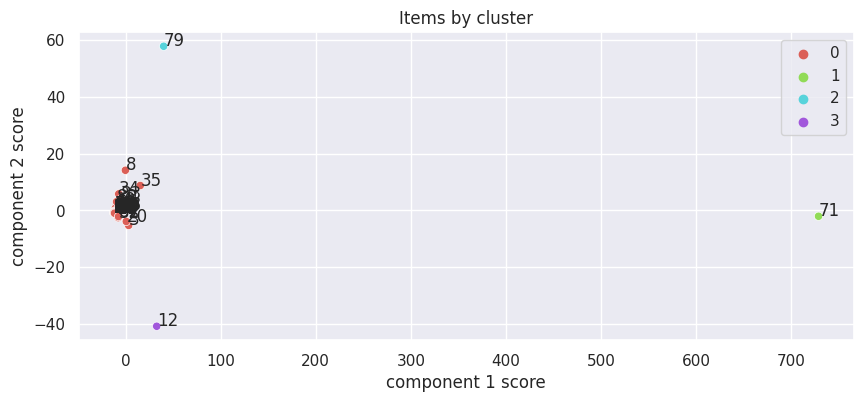

In [54]:
category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[])
matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

- Shop 은 각 item category의 총합 판매량으로 군집합니다.(=나뉘어져 그룹화됩니다.) 주성분그림를 그려보면 shop은 그들의 판매량에 의해 주로 차이를 가집니다. 
- Shop 31은 판매량으로 인해 이상치로 판정됩니다. Shop 12와 55는 서로 다른 (온라인 판매 전용) item을 팔고 있기 때문에 직교차원에서 이상치로 판정됩니다. (=서로 독립적이고 관련이 없습니다.)

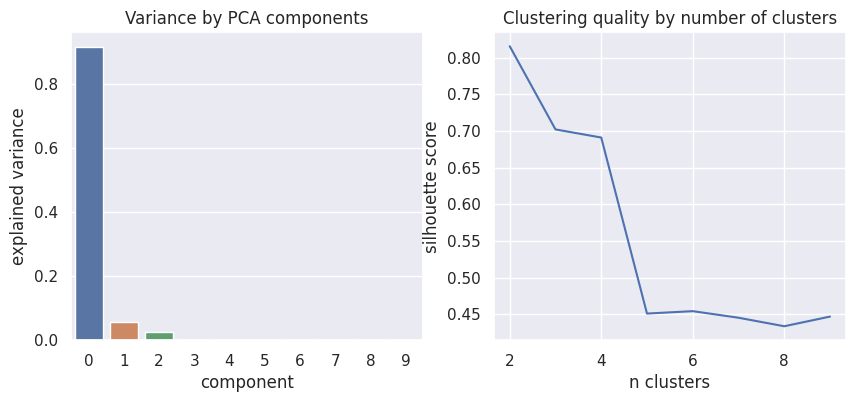

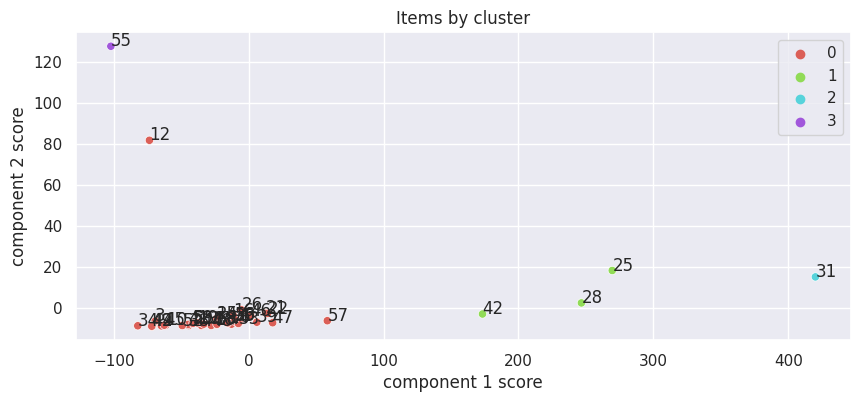

In [55]:
shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=4, aggfunc="mean", exclude=[36])
shop_group_dict[36] = shop_group_dict[37]  # Shop36 은 따로 더할 것인데 왜냐하면 한 달치 데이터만 가지고 있기 때문입니다.
matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [56]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory

# 고유 item 수에 의한 features
 
- (These features count the number of unique items sharing the same value of a grouping feature or set of features as the current item in the current month)
이 특성들은 이번 달의 현재 항목과 동일한 그룹화 특성 또는 특성 집합 값을 공유하는 고유 항목의 수를 계산합니다.

- 이는 일종의 데이터 유출로 여겨질 수 있습니다, 각 달의 item set이 예측한 달에 팔렸을지 안 팔렸을지 미리 알 수 없는 것처럼 말입니다.

In [57]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = (
            matrix.query(limitation)
            .groupby(groupers)
            .item_id.nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how="left")
    matrix[name] = matrix[name].fillna(0)
    return matrix


matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_name_group"],
    "name_group_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(
    matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month"
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "artist_name_or_first_word"],
    "first_word_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id"],
    "new_items_cat",
    limitation="new_item==True",
)
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix["name_group_new_proportion_month"] = (
    matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
)

matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])

In [58]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# 집계량 퍼센트화   
- 이는 Pandas 패키지의 pct_change 메서드를 사용해서 특정 그룹의 특정 시간대에 대한 평균 판매 횟수의 비율적 변화를 계산합니다. 예를 들어 '지난 2개월 간 특정 item의 평균판매수의 증가/변화 에 따른 내용' 같이요. 

In [59]:
def add_pct_change(
    matrix,
    group_feats,
    target="item_cnt_month",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["date_block_num"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad")) #pct change 는 pandas 의 method 로 이전 분기와의 percent change 를 나타냄
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["date_block_num"] += lag
    matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [60]:
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# Delta 1 feature lag 를 12로 놓는 것은, 계절적 영향을 캐치하기 위한 것입니다.
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
gc.collect()

Adding feature item_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_name_group_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_12


5

In [61]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)


# +)Window aggregation

- 전체 데이터의 볼륨이 클 경우 이를 윈도우 단위로 잘라서 처리할 수 있는 방법이 있는데, 예를 들어 10분 단위로 데이터를 처리해서, 10분 단위로 최소/최대 값을 구하거나 또는 10분 단위로 어떤 값의 평균값을 대표값으로 사용하는 것들이 이에 해당한다. 

- 일반적으로 입력값은 (entity, timestamp, value) 형태가 되며, 전처리된 출력 값은 다음과 같이. (entity, time_index, aggregated_value_over_time_window) 엔터티(피쳐)에 대해서 윈도우별로 처리된 값을 저장하는 형태가 된다.  보통 이런 window aggregation 방식은 리얼 타임 스트리밍 데이터에서 시간 윈도우 단위로 데이터를 처리하는 경우에 많이 사용이 되며, Apache Beam과 같은 스트리밍 프레임워크를 이용하여 구현한다. 

# Windowed aggregates

+) 일정 시간간격동안의 간격 = window

일종의 time filter 라고 보는 게 편하겠습니다. ex)window_size = n # n일간의 데이터를 갖고 다음 단일 타겟을 예측

noise(오차)를 줄이기 위해 특정 윈도우들을 집계한 특성입니다. 

접근가능한 window는 확장(=앞선 모든 시점들), 롤링(=동일한 가중치가 부여된 고정된 각 시점에 대한 가중치들) 및 지수가중평균이 있습니다.

A note about feature names: these are set automatically according to the pattern < grouping features > - < aggregated features > - < monthly aggregation function > - < window type > , where < window type > is either "rolling - < window aggregation function > - win - < window length in months >" for square rolling windows, "expanding - < window aggregation function >" for expanding windows, and "ewm_hl - < decay rate in terms of half-life > for exponential weighted means, all connected by underscores.

In [63]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [64]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # 특정 기능을 기준으로 그룹화하여 소스 테이블의 윈도우 섹션에 대해 통계치를 계산
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    """ 윈도우 기능을 사용할 때 물건이 팔리지 않았을 경우 올바르게 0으로 기록되는 대신 스킵되어 결측치로서 기록되는 문제를 확인했습니다. 
    pivot table을 만들면 0이 채워집니다."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # 0으로 취급되기보다 무시될 수 있도록, 상품이 처음 팔리기 전 시점에는 Nan 처리하세요.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}" #feature 이름 = feature 이름을 가져오고 _ 뒤에 join 할 feature 을 만든 다음 window 크기를 붙여.
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

롤링 특성 만들기. (이동평균의 상위버전)

그룹 특성과 윈도우 타입을 조합하여 만들어진 많은 특성들을 scikit-learn RFECV function을 사용하여 가지치기(pruning) 합니다.

Rolling Windows : 특정 window width (예: 10분, 1시간, 1일 등) 를 유지한채 측정 단위시간별로 이동하면서 분석 

Expanding Windows : 처음 시작 시점은 고정한 채, 시간이 흐름에 따라 신규로 포함되는 데이터까지 누적해서 분석

![img](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FblFckc%2FbtrhGNQDJ8w%2FPX5ohrbatKDfcVJzNYAxOK%2Fimg.png)

In [65]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(matrix, ["shop_id", "category_cluster"], window=12)
matrix = add_rolling_stats(\
                           
    matrix,
    ["shop_id", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group", "item_category_id", "new_item"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_cluster", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(matrix, ["item_id"], window=12)

matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], window=12)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(
    matrix,
    ["artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_category_id"], window=12)
matrix = add_rolling_stats(matrix, ["item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_name_group", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_name_group"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["item_name_group"], window=12)

matrix = add_rolling_stats(matrix, ["platform_id"], window=12)
matrix = add_rolling_stats(matrix, ["platform_id"], kind="ewm", window=1)

Creating feature "shop_id_artist_name_or_first_word_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_category_cluster_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "sh

In [66]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

이하의 코드들은 window의 평균 판매 특성들을 일자별로 정확도(resolution)를 나타낸 코드입니다.

엄밀히 말하면 resolution(분해능)은 정확도와 다른 개념이지만, 편리를 위해 정확도라고 번역하겠습니다.

+) Entity Resolution is a technique to identify data records in a single data source or across multiple data sources that refer to the same real-world entity and to link the records together.

https://m.blog.naver.com/instron_kor/220325603719  <- 설명을 참조하세요.

In [67]:
# 총 판매량 및 정확한 기간별 일일 평균 판매 특성
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="rolling",
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="expanding",
    reshape_source=False,
)
matrix["1year"] = 365
matrix["item_id_day_mean_expanding"] = matrix[
    "item_id_item_cnt_month_sum_expanding_sum"
] / matrix[["first_item_sale_days"]].min(axis=1)
matrix["shop_id_item_id_day_mean_win_12"] = matrix[
    "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
matrix.loc[matrix.new_item == True, "item_id_day_mean_expanding",] = float("nan")
matrix = matrix.drop(columns=["1year", "item_id_item_cnt_month_sum_expanding_sum"])

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"


# Revenue features 

In [68]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group"],
    window=12,
    argfeat="item_revenue_month",
    dtype="float32",
)

Creating feature "shop_id_item_name_group_item_revenue_month_mean_rolling_mean_win_12"


작년에 대한 윈도우 평균 unique item feature 과 카테고리 내 새 item의 비율과 평균

In [69]:
matrix = add_rolling_stats(
    matrix,
    ["item_category_id"],
    argfeat="new_items_cat",
    window=12,
    reshape_source=True,
    lag_offset=1,
)
matrix = add_rolling_stats(
    matrix,
    ["item_name_group"],
    argfeat="name_group_new_unique_month",
    window=12,
    reshape_source=True,
    lag_offset=1,
)

matrix["new_items_cat_1_12_ratio"] = (
    matrix["new_items_cat"]
    / matrix["item_category_id_new_items_cat_mean_rolling_mean_win_12"]
)

Creating feature "item_category_id_new_items_cat_mean_rolling_mean_win_12"
Creating feature "item_name_group_name_group_new_unique_month_mean_rolling_mean_win_12"


In [70]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Lagged features and mean encodings(시차 특성들과 mean encoding)
이전 달의 동일한 shop-item 조합에 대한 값들

In [71]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [72]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1,2,3]) # lag 1= 한달 전 데이터와 현재 데이터를 비교
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])
gc.collect()
print("Lag features created")

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_cnt_day_avg_lag_1
Adding feature item_cnt_day_avg_lag_2
Adding feature item_cnt_day_avg_lag_3
Adding feature item_revenue_month_lag_1
Lag features created


# Mean encoding(역자 첨부)

개요

1) 많은 distincts 변수들을 다룰 때, 많이 사용되는 기법으로 특히 tree-based 모델에서 유용하다.

2) 예측 : 각 category별로 평균 target 값을 세서 class의 label로 사용

3) 분류 : data point가 class 중 하나에 속할 가능성을 세서 class의 label로 사용

4) label encoding과 매우 유사하지만 target 값과 상관관계가 있어서 학습시키는데 좀 더 효율적이다.

 $$label_c=p_c$$
- p_c는 category_c의 target value의 평균값을 의미

**주의점**

- 학습데이터에 예측 값이 포함되기 때문에 train data에만 적용

- test data는 절대 사용하면 안된다.

## Mean Encoding 

각 카테고리 특성 수준에 따른 타겟 특성에 대한 평균 또는 총합 값과 카테고리의 특성들을 조합해서 사용

In [73]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

In [74]:
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month", aggfunc="sum")
matrix = create_apply_ME(matrix, ["item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_id"])
matrix = create_apply_ME(matrix, ["platform_id"])
matrix = create_apply_ME(matrix, ["item_name_group"])
matrix = create_apply_ME(matrix, ["platform_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["supercategory_id"])
matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])

Adding feature item_name_group_item_cnt_month_mean_lag_1
Adding feature item_name_group_item_cnt_month_sum_lag_1
Adding feature item_id_item_cnt_month_mean_lag_1
Adding feature item_id_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_day_avg_mean_lag_1
Adding feature item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_month_mean_lag_1
Adding feature supercategory_id_item_cnt_day_avg_mean_lag_1
Adding feature item_category_id_new_item_item_cnt_month_mean_lag_1
Adding feature shop_id_item_category_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_name_group_item_cnt_day_avg_mean_lag_1


lag 1 sales와 rolling 12개월 평균 사이의 비율은 이전 평균의 감소를 포착하기 위한 것입니다.((lag_1의 mean) 에서 rolling_mean_win_12는 얼마만큼 감소했는지)

In [75]:
matrix["item_id_item_cnt_1_12_ratio"] = (
    matrix["item_id_item_cnt_month_mean_lag_1"]
    / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
)
matrix["shop_id_item_id_item_cnt_1_12_ratio"] = (
    matrix["item_cnt_day_avg_lag_1"] / matrix["shop_id_item_id_day_mean_win_12"]
)

In [76]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint.pkl")
print("Saved matrixcheckpoint")
gc.collect()
print("Mean encoding features created")

Saved matrixcheckpoint
Mean encoding features created


몇몇 column 들은 다른 feature을 만들기 위해 제작되었으나 현재는 폐기되었습니다.

In [77]:
surplus_columns = [
    "item_revenue_month",
    "item_cnt_day_avg",
    "item_name_group",
    "artist_name_or_first_word",
    "item_age",
    "shop_open_days",
    "shop_age",
    "platform_id",
    "supercategory_id",
    "city_code",
    "category_cluster",
    "shop_cluster",
    "new_items_cat",
    "shop_id_item_id_day_mean_win_12",
    "item_id_item_cnt_month_mean_rolling_mean_win_12",
]
matrix = matrix.drop(columns=surplus_columns)

In [78]:
matrix.head().T

0       1       2  \
date_block_num                                          0.0     0.0     0.0   
shop_id                                                59.0    59.0    59.0   
item_id                                             22154.0  2552.0  2554.0   
item_cnt_month                                          1.0     0.0     0.0   
item_name_length                                       17.0    40.0    40.0   
...                                                     ...     ...     ...   
shop_cluster_item_id_item_cnt_day_avg_mean_lag_1        NaN     NaN     NaN   
city_code_item_id_item_cnt_day_avg_mean_lag_1           NaN     NaN     NaN   
city_code_item_name_group_item_cnt_day_avg_mean...      NaN     NaN     NaN   
item_id_item_cnt_1_12_ratio                             NaN     NaN     NaN   
shop_id_item_id_item_cnt_1_12_ratio                     NaN     NaN     NaN   

                                                         3       4  
date_block_num                                         0.0     0.0  
shop_id                                               59.0    59.0  
item_id                                             2555.0  2564.0  
item_cnt_month                                         0.0     0.0  
item_name_length                                      39.0    50.0  
...                                                    ...     ...  
shop_cluster_item_id_item_cnt_day_avg_mean_lag_1       NaN     NaN  
city_code_item_id_item_cnt_day_avg_mean_lag_1          NaN     NaN  
city_code_item_name_group_item_cnt_day_avg_mean...     NaN     NaN  
item_id_item_cnt_1_12_ratio                            NaN     NaN  
shop_id_item_id_item_cnt_1_12_ratio                    NaN     NaN  

[94 rows x 5 columns]

# Predictive words in item_name

One-hot feautre 은 item_name 단어들로 item sales를 예측하기 위해 만들어졌습니다. 

항목 이름에서 찾은 1000 개의 단어에서 *k* 단어 feature을 선택하기 위해 item의 임계값 수의 이름에 없거나 test 나 validation month에 없는 item 이름들은 버려집니다. 

남은 단어들은 scikit-learn SelectKBest function 에 의해 그들의 타겟과의 상관관계에 따라 선택됩니다. 

In [81]:
import re
import warnings

warnings.filterwarnings("ignore", module="sklearn")

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression


def name_token_feats(matrix, items, k=50, item_n_threshold=5, target_month_start=33): #단어 토큰화
    def name_correction(st):
        st = re.sub(r"[^\w\s]", "", st)#문자클래스, whitespace가 아닌 문자를 제거
        st = re.sub(r"\s{2,}", " ", st)#whitespace가 두번 이상 반복된 문자를 제거
        st = st.lower().strip() #공백 제거
        return st

    items["item_name_clean"] = items["item_name"].apply(name_correction)

    def create_item_id_bow_matrix(items):
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")

        vectorizer = CountVectorizer(stop_words=all_stopwords) #벡터화
        X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
        X = pd.DataFrame.sparse.from_spmatrix(X)
        print(f"{len(vectorizer.vocabulary_)} words found in all items")
        featuremap = {
            col: "word_" + token
            for col, token in zip(
                range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names_out()
            )
        }
        X = X.rename(columns=featuremap)
        return X

    items_bow = create_item_id_bow_matrix(items)
    items_bow = items_bow.clip(0, 1)  # 단어 카운트를 이진화
    common_word_mask = items_bow.sum(axis=0) > item_n_threshold
    target_items = matrix.query(
        f"date_block_num>={target_month_start} & new_item==True"
    ).item_id.unique()
    target_item_mask = items_bow.loc[target_items, :].sum(axis=0) > 1
    items_bow = items_bow.loc[:, common_word_mask & target_item_mask]
    print(f"{items_bow.shape[1]} words of interest")
    mxbow = matrix[["date_block_num", "item_id", "item_cnt_month"]].query("date_block_num<34")
    mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")
    X = mxbow.drop(columns=["date_block_num", "item_id", "item_cnt_month"])
    y = mxbow["item_cnt_month"].clip(0, 20)
    selektor = SelectKBest(f_regression, k=k)
    selektor.fit(X, y)
    tokencols = X.columns[selektor.get_support()]
    print(f"{k} word features selected")
    return items_bow[tokencols]

In [82]:
items = pd.read_csv(PATH+"items.csv")
word_frame = name_token_feats(matrix, items, k=50, item_n_threshold=5)
matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')
# LightGBM didn't seem to work with sparse features in this case, so we'll convert them to int
# sparse data는 차원/전체 공간에 비해 데이터가 있는 공간이 매우 협소한 데이터를 의미합니다. 희소행렬을 생각해보세요.
sparsecols = [c for c in matrix.columns if pd.api.types.is_sparse(matrix[c].dtype)]
matrix[sparsecols] = matrix[sparsecols].sparse.to_dense().astype('int8')

19134 words found in all items
449 words of interest
50 word features selected


In [83]:
pd.set_option('display.max_rows', None)
matrix.head().T

0            1  \
date_block_num                                          0.000000     0.000000   
shop_id                                                59.000000    59.000000   
item_id                                             22154.000000  2552.000000   
item_cnt_month                                          1.000000     0.000000   
item_name_length                                       17.000000    40.000000   
item_name_cleaned_length                               13.000000    38.000000   
first_item_sale_days                                 9999.000000  9999.000000   
first_shop_item_sale_days                            9999.000000  9999.000000   
first_name_group_sale_days                           9999.000000  9999.000000   
last_shop_item_sale_days                             9999.000000  9999.000000   
month                                                   1.000000     1.000000   
quarter                                                 1.000000     1.000000   
new_item                                                1.000000     1.000000   
last_item_price                                              NaN          NaN   
last_norm_diff_cat_price                                     NaN          NaN   
item_category_id                                       37.000000    58.000000   
name_group_cat_unique_month                             1.000000     1.000000   
name_group_new_unique_month                             2.000000     1.000000   
name_group_new_cat_unique_month                         1.000000     1.000000   
first_word_unique_month                                 2.000000    23.000000   
first_word_cat_unique_month                             1.000000     8.000000   
first_word_new_unique_month                             2.000000    23.000000   
first_word_new_cat_unique_month                         1.000000     8.000000   
unique_items_cat                                      620.000000   132.000000   
new_items_month                                      7644.000000  7644.000000   
cat_items_proportion                                    0.081109     0.017268   
name_group_new_proportion_month                         1.000000     1.000000   
item_id_item_cnt_month_mean_delta_1_lag_1                    NaN          NaN   
item_category_id_item_cnt_month_mean_delta_1_lag_1           NaN          NaN   
item_name_group_item_cnt_month_mean_delta_1_lag_1            NaN          NaN   
item_category_id_item_cnt_month_mean_delta_1_la...           NaN          NaN   
shop_id_artist_name_or_first_word_item_category...           NaN          NaN   
shop_id_artist_name_or_first_word_item_category...           NaN          NaN   
shop_id_artist_name_or_first_word_new_item_item...           NaN          NaN   
shop_id_category_cluster_item_cnt_month_mean_ro...           NaN          NaN   
shop_id_item_category_id_item_age_item_cnt_mont...           NaN          NaN   
shop_id_item_category_id_item_age_item_cnt_mont...           NaN          NaN   
shop_id_item_category_id_item_cnt_month_mean_ew...           NaN          NaN   
shop_id_item_category_id_new_item_item_cnt_mont...           NaN          NaN   
shop_id_item_category_id_new_item_item_cnt_mont...           NaN          NaN   
shop_id_item_cnt_month_mean_rolling_mean_win_12              NaN          NaN   
shop_id_item_id_item_cnt_month_mean_ewm_hl_1                 NaN          NaN   
shop_id_item_id_item_cnt_month_mean_rolling_mea...           NaN          NaN   
shop_id_item_name_group_item_category_id_new_it...           NaN          NaN   
shop_id_item_name_group_new_item_item_cnt_month...           NaN          NaN   
shop_id_supercategory_id_new_item_item_cnt_mont...           NaN          NaN   
shop_cluster_item_id_item_cnt_month_mean_ewm_hl_1            NaN          NaN   
shop_cluster_item_category_id_item_age_item_cnt...           NaN          NaN   
shop_cluster_item_name_group_new_item_item_cnt_...           NaN          NaN   
category_clus

마지막 feature frame은 저장한 후 노트북 커널을 리셋하여 LightGBM 을 돌리기 위한 메모리를 확보합니다. 

In [84]:
gc.collect()
matrix.to_pickle("checkpoint_final_0.84.pkl")
print("All features generated, dataframe saved")

All features generated, dataframe saved


In [85]:
%reset -f

# OPTUNA

- feature matrix 에서 train 과 validation set을 나눕니다. 33 개의 month는 validation set으로 사용됩니다. 
- 이러한 하이퍼파라미터는 검증 세트에 대한 하이퍼파라미터를 최적화하기 위해 하이퍼파라미터 최적화 프레임워크 Optuna를 사용하여 발견되었습니다.

https://ssoonidev.tistory.com/107


# model fitting part

In [1]:
import warnings

warnings.filterwarnings("ignore", module="lightgbm")

import lightgbm as lgbm


def fit_booster(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    params=None,
    test_run=False,
    categoricals=[],
    dropcols=[],
    early_stopping=True,
):
    if params is None:
        params = {"learning_rate": 0.1, "subsample_for_bin": 300000, "n_estimators": 50}

    early_stopping_rounds = None
    if early_stopping == True:
        early_stopping_rounds = 30

    if test_run:
        eval_set = [(X_train, y_train)]
    else:
        eval_set = [(X_train, y_train), (X_test, y_test)]

    booster = lgbm.LGBMRegressor(**params)

    categoricals = [c for c in categoricals if c in X_train.columns]

    booster.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["rmse"],
        verbose=100,
        categorical_feature=categoricals,
        early_stopping_rounds=early_stopping_rounds,
    )

    return booster

# 동선

In [2]:
import pandas as pd
import numpy as np

df = pd.read_pickle("/mnt/c/Users/KOJUNSUNG/Desktop/lab/git/TIL/kaggle/checkpoint_final_0.84.pkl")  
#pkl is much faster and much lower in memory
df['item_cnt_month'] = df['item_cnt_month'].clip(0,20)
df=df.rename(columns={"item_cnt_month":"item_cnt"})
df=df[df!=np.inf] #결측치 제거 작업

In [3]:
#designating the categorical features which should be focused on
import pandas as pd
import numpy as np
import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore")

def build_lgb_model(X_train,y_train):
    params = {
        'objective': 'rmse',
        'metric': 'rmse',
        'num_leaves': 1023,
        'min_data_in_leaf':10,
        'feature_fraction':0.7,
        'learning_rate': 0.01,
        'num_rounds': 500,
    #     'early_stopping_rounds': 30,
        'seed': 1
    }
        
    cat_features = ['item_category_id','month','shop_id']
    lgb_train = lgb.Dataset(X_train, y_train)
    model = lgb.train(params=params, train_set=lgb_train,valid_sets=lgb_train,verbose_eval=10,
                     categorical_feature=cat_features)
    return model

In [4]:
keep_from_month = 2  # 첫 두달은 제외되었는데, 왜냐하면 특성에 왜곡이 있었기 때문입니다. (e.g. 잘못된 item age)
test_month = 33
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # 이 특성들은 오버피팅을 막기 위해 떨궈냈습니다.

In [5]:
params = {
    "cat_smooth": 45.01680827234465,
    "min_child_samples": 27,
    "min_child_weight": 0.021144950289224463,
    "max_bin": 214,
    "learning_rate": 0.01,
    "subsample_for_bin": 300000,
    "min_data_in_bin": 7,
    "colsample_bytree": 0.8,
    "subsample": 0.6,
    "subsample_freq": 5,
    "n_estimators": 750,
}

In [7]:
import joblib

In [6]:
import xgboost as xgb
import mlflow 

In [95]:


path = "/mnt/c/Users/KOJUNSUNG/Desktop/lab/kaggle/"
preds_arr_lgb=[]
vals_arr_lgb=[]
vals_arr_lgb_84=[]
preds_arr_xgb=[]
vals_arr_xgb=[]
preds_arr_nn=[]
shop_id=[]
item_id=[]
cat_id=[]
month_arr=[]
for i in range(25,35):
    X_train=df[df["date_block_num"]<i].drop(['item_cnt',"date_block_num"],axis=1)
    y_train=df.loc[(df["date_block_num"]<i),'item_cnt']
    X_val=df[df["date_block_num"]==i].drop(['item_cnt',"date_block_num"],axis=1)
    y_val=df.loc[(df["date_block_num"]==i),'item_cnt']
    


    #########################XGB################################
    model_name="XGB_iterations_100"+str(i)
    mlflow.xgboost.autolog(registered_model_name=model_name)
    SEED=0
    xgb_model = xgb.XGBRegressor(learning_rate=0.05,max_leaves=800,num_round=1000,n_estimators=100,max_depth=10,early_stopping_rounds=10)
    xgb_model.fit(X_train,y_train,eval_metric="rmse",eval_set=[(X_train,y_train)])
    val_pred=xgb_model.predict(X_val).clip(0,20)
    vals_arr_xgb.append(val_pred)
    ######################################################################
    categoricals = [
    "item_category_id",
    "month",
        ]  # These features will be set as categorical features by LightGBM and handled differently
    
    mlflow.lightgbm.autolog(registered_model_name=model_name)
   
    lgbooster = fit_booster(
        X_train,
        y_train,
        X_val,
        y_val,
        params=params,
        test_run=True,
        categoricals=categoricals,
    )
    val_pred=lgbooster.predict(X_val).clip(0,20)
    vals_arr_lgb_84.append(val_pred)
    
        #########################LGB###############################
    model_name="LGB_iteration_750"+str(i)
    mlflow.lightgbm.autolog(registered_model_name=model_name)
    lgb_model = build_lgb_model(X_train, y_train)
    val_pred=lgb_model.predict(X_val).clip(0,20)
    
    vals_arr_lgb.append(val_pred)
    
    
    shop_id.append(X_val["shop_id"].values)
    item_id.append(X_val["item_id"].values)
    cat_id.append(X_val["item_category_id"].values)
    month_arr.append(X_val["month"].values)
    preds_arr_lgb.append([y_val])
    
    _ = joblib.dump(xgb_model, "xgb_model_"+str(i)+"_.pkl")
    _ = joblib.dump(lgb_model, "lgb_model"+str(i)+"_.pkl")
    _ = joblib.dump(lgbooster, "lgbooster"+str(i)+"_.pkl")
    
  
vals_arr_xgb_series=pd.Series(vals_arr_xgb)
vals_arr_xgb_series.to_pickle(path+'vals_arr_xgb_84.pkl')
    

vals_arr_lgb_series=pd.Series(vals_arr_lgb)
vals_arr_lgb_series.to_pickle(path+'vals_arr_lgb_84.pkl')

vals_arr_lgb_series_84s=pd.Series(vals_arr_lgb_84)
vals_arr_lgb_series_84s.to_pickle(path+'vals_arr_lgb_84s.pkl')

2023/01/19 10:21:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5c298252510d454a817423bed8838a0d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[10:22:01] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.26089
[1]	validation_0-rmse:1.22891
[2]	validation_0-rmse:1.19897
[3]	validation_0-rmse:1.17079
[4]	validation_0-rmse:1.14497
[5]	validation_0-rmse:1.12078
[6]	validation_0-rmse:1.09783
[7]	validation_0-rmse:1.07684
[8]	validation_0-rmse:1.05716
[9]	validation_0-rmse:1.03878
[10]	validation_0-rmse:1.02185
[11]	validation_0-rmse:1.00566
[12]	validation_0-rmse:0.99071
[13]	validation_0-rmse:0.97657
[14]	validation_0-rmse:0.96338
[15]	validation_0-rmse:0.95147
[16]	validation_0-rmse:0.94000
[17]	validation_0-rmse:0.92911
[18]	validation_0-rmse:0.91932
[19]	validation_0-rmse:0.90994
[20]	validation_0-rmse:0.90109
[21]	validation_0-rmse:0.89320
[22]	validation_0-rmse:0.88530
[23]	validation_0-rmse:0.87801
[24]	validation_0-rmse:0.87117
[25]	validation_0-rmse:0.86474
[26]	validation_0-rmse:0.85864
[27]	validation_0-rmse:0.85338
[28]	validation_0-rmse:0.84811
[29]	validation_0-rmse:0

Registered model 'XGB_iterations_10025' already exists. Creating a new version of this model...
2023/01/19 10:25:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10025, version 3
Created version '3' of model 'XGB_iterations_10025'.
2023/01/19 10:25:36 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 10:25:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e62fc0cbb20431b9cfe3f66926425e9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.983028	training's l2: 0.966344
[200]	training's rmse: 0.903032	training's l2: 0.815467
[300]	training's rmse: 0.872095	training's l2: 0.760549
[400]	training's rmse: 0.854925	training's l2: 0.730896
[500]	training's rmse: 0.842404	training's l2: 0.709644
[600]	training's rmse: 0.831972	training's l2: 0.692178
[700]	training's rmse: 0.823126	training's l2: 0.677537


2023/01/19 10:28:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1e62fc0cbb20431b9cfe3f66926425e9. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10025' already exists. Creating a new version of this model...
2023/01/19 10:28:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10025, version 4
Created version '4' of model 'XGB_iterations_10025'.
2023/01/19 10:28:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.482677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19293
[LightGBM] [Info] Number of data points in the train set: 6664152, number of used features: 142
[LightGBM] [Info] Start training from score 0.323850
[10]	training's rmse: 1.21207
[20]	training's rmse: 1.14879
[30]	training's rmse: 1.09303
[40]	training's rmse: 1.04435
[50]	training's rmse: 1.00166
[60]	training's rmse: 0.964098
[70]	training's rmse: 0.931139
[80]	training's rmse: 0.902588
[90]	training's rmse: 0.877438
[100]	training's rmse: 0.85537
[110]	training's rmse: 0.836012
[120]	training's rmse: 0.818731
[130]	training's rmse: 0.80336
[140]	training's rmse: 0.789935
[150]	training's rmse: 0.778031
[160]	training's rmse: 0.7675
[170]	training's rmse: 0.757988
[180]	training's rmse: 0.749534
[190]	training's rmse: 0.7418

Registered model 'LGB_iteration_75025' already exists. Creating a new version of this model...
2023/01/19 10:34:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75025, version 2
Created version '2' of model 'LGB_iteration_75025'.
2023/01/19 10:34:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e6452c10bfb3416eb13cfb70c10b32bf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[10:34:57] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.25514
[1]	validation_0-rmse:1.22333
[2]	validation_0-rmse:1.19362
[3]	validation_0-rmse:1.16551
[4]	validation_0-rmse:1.13967
[5]	validation_0-rmse:1.11563
[6]	validation_0-rmse:1.09294
[7]	validation_0-rmse:1.07186
[8]	validation_0-rmse:1.05208
[9]	validation_0-rmse:1.03387
[10]	validation_0-rmse:1.01636
[11]	validation_0-rmse:1.00061
[12]	validation_0-rmse:0.98579
[13]	validation_0-rmse:0.97165
[14]	validation_0-rmse:0.95887
[15]	validation_0-rmse:0.94674
[16]	validation_0-rmse:0.93544
[17]	validation_0-rmse:0.92510
[18]	validation_0-rmse:0.91531
[19]	validation_0-rmse:0.90609
[20]	validation_0-rmse:0.89739
[21]	validation_0-rmse:0.88910
[22]	validation_0-rmse:0.88161
[23]	validation_0-rmse:0.87445
[24]	validation_0-rmse:0.86747
[25]	validation_0-rmse:0.86081
[26]	validation_0-rmse:0.85485
[27]	validation_0-rmse:0.84927
[28]	validation_0-rmse:0.84382
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10026'.
2023/01/19 10:38:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10026, version 1
Created version '1' of model 'XGB_iterations_10026'.
2023/01/19 10:38:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 10:38:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2faa2e11288b4532b14fadf3b7d1fb54', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.978763	training's l2: 0.957977
[200]	training's rmse: 0.899733	training's l2: 0.809519
[300]	training's rmse: 0.869253	training's l2: 0.755601
[400]	training's rmse: 0.852248	training's l2: 0.726326
[500]	training's rmse: 0.84019	training's l2: 0.70592
[600]	training's rmse: 0.8296	training's l2: 0.688237
[700]	training's rmse: 0.821047	training's l2: 0.674119


2023/01/19 10:41:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 2faa2e11288b4532b14fadf3b7d1fb54. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10026' already exists. Creating a new version of this model...
2023/01/19 10:41:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10026, version 2
Created version '2' of model 'XGB_iterations_10026'.
2023/01/19 10:41:29 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.492816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19245
[LightGBM] [Info] Number of data points in the train set: 6904043, number of used features: 142
[LightGBM] [Info] Start training from score 0.322487
[10]	training's rmse: 1.20664
[20]	training's rmse: 1.14396
[30]	training's rmse: 1.08871
[40]	training's rmse: 1.04052
[50]	training's rmse: 0.998091
[60]	training's rmse: 0.960917
[70]	training's rmse: 0.92841
[80]	training's rmse: 0.900289
[90]	training's rmse: 0.875369
[100]	training's rmse: 0.853524
[110]	training's rmse: 0.834377
[120]	training's rmse: 0.817346
[130]	training's rmse: 0.802239
[140]	training's rmse: 0.788986
[150]	training's rmse: 0.777319
[160]	training's rmse: 0.766889
[170]	training's rmse: 0.757474
[180]	training's rmse: 0.749146
[190]	training's rmse: 0.

Successfully registered model 'LGB_iteration_75026'.
2023/01/19 10:47:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75026, version 1
Created version '1' of model 'LGB_iteration_75026'.
2023/01/19 10:47:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f560114d5c4c4fbea0e96f69b375c74b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[10:48:04] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.24967
[1]	validation_0-rmse:1.21795
[2]	validation_0-rmse:1.18835
[3]	validation_0-rmse:1.16034
[4]	validation_0-rmse:1.13453
[5]	validation_0-rmse:1.11010
[6]	validation_0-rmse:1.08772
[7]	validation_0-rmse:1.06648
[8]	validation_0-rmse:1.04705
[9]	validation_0-rmse:1.02862
[10]	validation_0-rmse:1.01199
[11]	validation_0-rmse:0.99644
[12]	validation_0-rmse:0.98152
[13]	validation_0-rmse:0.96760
[14]	validation_0-rmse:0.95481
[15]	validation_0-rmse:0.94290
[16]	validation_0-rmse:0.93150
[17]	validation_0-rmse:0.92105
[18]	validation_0-rmse:0.91142
[19]	validation_0-rmse:0.90237
[20]	validation_0-rmse:0.89390
[21]	validation_0-rmse:0.88578
[22]	validation_0-rmse:0.87819
[23]	validation_0-rmse:0.87086
[24]	validation_0-rmse:0.86417
[25]	validation_0-rmse:0.85784
[26]	validation_0-rmse:0.85185
[27]	validation_0-rmse:0.84616
[28]	validation_0-rmse:0.84097
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10027'.
2023/01/19 10:51:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10027, version 1
Created version '1' of model 'XGB_iterations_10027'.
2023/01/19 10:51:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 10:51:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2a0b8086f9d44fc09744e027ce6544e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.973881	training's l2: 0.948444
[200]	training's rmse: 0.895397	training's l2: 0.801735
[300]	training's rmse: 0.865124	training's l2: 0.748439
[400]	training's rmse: 0.848444	training's l2: 0.719857
[500]	training's rmse: 0.836209	training's l2: 0.699246
[600]	training's rmse: 0.825818	training's l2: 0.681975
[700]	training's rmse: 0.817381	training's l2: 0.668112


2023/01/19 10:54:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 2a0b8086f9d44fc09744e027ce6544e8. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10027' already exists. Creating a new version of this model...
2023/01/19 10:54:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10027, version 2
Created version '2' of model 'XGB_iterations_10027'.
2023/01/19 10:54:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.393175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19278
[LightGBM] [Info] Number of data points in the train set: 7145205, number of used features: 142
[LightGBM] [Info] Start training from score 0.320934
[10]	training's rmse: 1.20095
[20]	training's rmse: 1.13867
[30]	training's rmse: 1.08371
[40]	training's rmse: 1.0357
[50]	training's rmse: 0.993567
[60]	training's rmse: 0.956777
[70]	training's rmse: 0.924426
[80]	training's rmse: 0.896465
[90]	training's rmse: 0.871696
[100]	training's rmse: 0.850094
[110]	training's rmse: 0.831211
[120]	training's rmse: 0.814229
[130]	training's rmse: 0.799275
[140]	training's rmse: 0.786187
[150]	training's rmse: 0.7746
[160]	training's rmse: 0.764363
[170]	training's rmse: 0.755079
[180]	training's rmse: 0.746805
[190]	training's rmse: 0.73

Successfully registered model 'LGB_iteration_75027'.
2023/01/19 11:00:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75027, version 1
Created version '1' of model 'LGB_iteration_75027'.
2023/01/19 11:00:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '79fe7854a86a442d9bf068b0169de11b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[11:00:27] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.24647
[1]	validation_0-rmse:1.21492
[2]	validation_0-rmse:1.18515
[3]	validation_0-rmse:1.15736
[4]	validation_0-rmse:1.13164
[5]	validation_0-rmse:1.10742
[6]	validation_0-rmse:1.08525
[7]	validation_0-rmse:1.06467
[8]	validation_0-rmse:1.04513
[9]	validation_0-rmse:1.02714
[10]	validation_0-rmse:1.01003
[11]	validation_0-rmse:0.99414
[12]	validation_0-rmse:0.97931
[13]	validation_0-rmse:0.96577
[14]	validation_0-rmse:0.95299
[15]	validation_0-rmse:0.94116
[16]	validation_0-rmse:0.92987
[17]	validation_0-rmse:0.91929
[18]	validation_0-rmse:0.90948
[19]	validation_0-rmse:0.90042
[20]	validation_0-rmse:0.89194
[21]	validation_0-rmse:0.88380
[22]	validation_0-rmse:0.87624
[23]	validation_0-rmse:0.86921
[24]	validation_0-rmse:0.86277
[25]	validation_0-rmse:0.85643
[26]	validation_0-rmse:0.85045
[27]	validation_0-rmse:0.84480
[28]	validation_0-rmse:0.83968
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10028'.
2023/01/19 11:04:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10028, version 1
Created version '1' of model 'XGB_iterations_10028'.
2023/01/19 11:04:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 11:04:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8136fb3f9539472da30e8330c86a8b85', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.971469	training's l2: 0.943753
[200]	training's rmse: 0.893379	training's l2: 0.798127
[300]	training's rmse: 0.862985	training's l2: 0.744743
[400]	training's rmse: 0.846059	training's l2: 0.715816
[500]	training's rmse: 0.834151	training's l2: 0.695809
[600]	training's rmse: 0.823759	training's l2: 0.678578
[700]	training's rmse: 0.815519	training's l2: 0.665072


2023/01/19 11:07:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 8136fb3f9539472da30e8330c86a8b85. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10028' already exists. Creating a new version of this model...
2023/01/19 11:07:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10028, version 2
Created version '2' of model 'XGB_iterations_10028'.
2023/01/19 11:07:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19417
[LightGBM] [Info] Number of data points in the train set: 7366605, number of used features: 142
[LightGBM] [Info] Start training from score 0.319080
[10]	training's rmse: 1.19719
[20]	training's rmse: 1.13526
[30]	training's rmse: 1.08057
[40]	training's rmse: 1.03287
[50]	training's rmse: 0.991089
[60]	training's rmse: 0.954411
[70]	training's rmse: 0.922242
[80]	training's rmse: 0.894533
[90]	training's rmse: 0.869957
[100]	training's rmse: 0.848417
[110]	training's rmse: 0.829561
[120]	training's rmse: 0.812691
[130]	training's rmse: 0.79774
[140]	training's rmse: 0.784736
[150]	training's rmse: 0.773234
[160]	training's rmse: 0.763092
[170]	training's rmse: 0.753876
[180]	training's rmse: 0.74564
[190]	training's rmse: 0.7

Successfully registered model 'LGB_iteration_75028'.
2023/01/19 11:12:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75028, version 1
Created version '1' of model 'LGB_iteration_75028'.
2023/01/19 11:12:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd2aad1e496974f4e90c031711ec68dbf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[11:12:54] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.24167
[1]	validation_0-rmse:1.21013
[2]	validation_0-rmse:1.18039
[3]	validation_0-rmse:1.15306
[4]	validation_0-rmse:1.12751
[5]	validation_0-rmse:1.10315
[6]	validation_0-rmse:1.08109
[7]	validation_0-rmse:1.06064
[8]	validation_0-rmse:1.04118
[9]	validation_0-rmse:1.02325
[10]	validation_0-rmse:1.00633
[11]	validation_0-rmse:0.99055
[12]	validation_0-rmse:0.97593
[13]	validation_0-rmse:0.96212
[14]	validation_0-rmse:0.94938
[15]	validation_0-rmse:0.93765
[16]	validation_0-rmse:0.92669
[17]	validation_0-rmse:0.91618
[18]	validation_0-rmse:0.90631
[19]	validation_0-rmse:0.89712
[20]	validation_0-rmse:0.88865
[21]	validation_0-rmse:0.88078
[22]	validation_0-rmse:0.87356
[23]	validation_0-rmse:0.86638
[24]	validation_0-rmse:0.85973
[25]	validation_0-rmse:0.85338
[26]	validation_0-rmse:0.84748
[27]	validation_0-rmse:0.84194
[28]	validation_0-rmse:0.83682
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10029'.
2023/01/19 11:16:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10029, version 1
Created version '1' of model 'XGB_iterations_10029'.
2023/01/19 11:16:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 11:16:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ccf5cdd0123b495db5a28ef605a17d57', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.967518	training's l2: 0.936091
[200]	training's rmse: 0.889611	training's l2: 0.791407
[300]	training's rmse: 0.859404	training's l2: 0.738575
[400]	training's rmse: 0.842526	training's l2: 0.70985
[500]	training's rmse: 0.830499	training's l2: 0.689729
[600]	training's rmse: 0.820267	training's l2: 0.672838
[700]	training's rmse: 0.812247	training's l2: 0.659744


2023/01/19 11:19:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID ccf5cdd0123b495db5a28ef605a17d57. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10029' already exists. Creating a new version of this model...
2023/01/19 11:19:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10029, version 2
Created version '2' of model 'XGB_iterations_10029'.
2023/01/19 11:19:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.490906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19352
[LightGBM] [Info] Number of data points in the train set: 7579108, number of used features: 142
[LightGBM] [Info] Start training from score 0.317462
[10]	training's rmse: 1.19281
[20]	training's rmse: 1.13102
[30]	training's rmse: 1.07667
[40]	training's rmse: 1.02925
[50]	training's rmse: 0.98766
[60]	training's rmse: 0.95119
[70]	training's rmse: 0.919229
[80]	training's rmse: 0.891592
[90]	training's rmse: 0.867162
[100]	training's rmse: 0.845713
[110]	training's rmse: 0.826932
[120]	training's rmse: 0.810257
[130]	training's rmse: 0.795443
[140]	training's rmse: 0.782589
[150]	training's rmse: 0.771212
[160]	training's rmse: 0.761065
[170]	training's rmse: 0.751855
[180]	training's rmse: 0.743709
[190]	training's rmse: 0.7

Successfully registered model 'LGB_iteration_75029'.
2023/01/19 11:25:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75029, version 1
Created version '1' of model 'LGB_iteration_75029'.
2023/01/19 11:26:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '321ba51427744d51aed0c02d8a9c9083', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[11:26:07] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.23721
[1]	validation_0-rmse:1.20592
[2]	validation_0-rmse:1.17665
[3]	validation_0-rmse:1.14951
[4]	validation_0-rmse:1.12411
[5]	validation_0-rmse:1.10056
[6]	validation_0-rmse:1.07864
[7]	validation_0-rmse:1.05777
[8]	validation_0-rmse:1.03835
[9]	validation_0-rmse:1.02025
[10]	validation_0-rmse:1.00320
[11]	validation_0-rmse:0.98764
[12]	validation_0-rmse:0.97281
[13]	validation_0-rmse:0.95927
[14]	validation_0-rmse:0.94650
[15]	validation_0-rmse:0.93475
[16]	validation_0-rmse:0.92370
[17]	validation_0-rmse:0.91341
[18]	validation_0-rmse:0.90360
[19]	validation_0-rmse:0.89445
[20]	validation_0-rmse:0.88608
[21]	validation_0-rmse:0.87793
[22]	validation_0-rmse:0.87067
[23]	validation_0-rmse:0.86348
[24]	validation_0-rmse:0.85680
[25]	validation_0-rmse:0.85054
[26]	validation_0-rmse:0.84477
[27]	validation_0-rmse:0.83929
[28]	validation_0-rmse:0.83388
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10030'.
2023/01/19 11:29:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10030, version 1
Created version '1' of model 'XGB_iterations_10030'.
2023/01/19 11:29:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 11:29:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cbfff2e5ca53486e98c3d0d469fdf06f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.963841	training's l2: 0.928989
[200]	training's rmse: 0.885986	training's l2: 0.784972
[300]	training's rmse: 0.856008	training's l2: 0.732749
[400]	training's rmse: 0.839684	training's l2: 0.70507
[500]	training's rmse: 0.827743	training's l2: 0.685158
[600]	training's rmse: 0.817865	training's l2: 0.668903
[700]	training's rmse: 0.810038	training's l2: 0.656162


2023/01/19 11:33:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID cbfff2e5ca53486e98c3d0d469fdf06f. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10030' already exists. Creating a new version of this model...
2023/01/19 11:33:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10030, version 2
Created version '2' of model 'XGB_iterations_10030'.
2023/01/19 11:33:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.704078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19438
[LightGBM] [Info] Number of data points in the train set: 7789438, number of used features: 142
[LightGBM] [Info] Start training from score 0.316032
[10]	training's rmse: 1.18804
[20]	training's rmse: 1.12665
[30]	training's rmse: 1.07261
[40]	training's rmse: 1.02541
[50]	training's rmse: 0.984063
[60]	training's rmse: 0.947856
[70]	training's rmse: 0.916117
[80]	training's rmse: 0.888597
[90]	training's rmse: 0.86434
[100]	training's rmse: 0.843172
[110]	training's rmse: 0.824598
[120]	training's rmse: 0.808057
[130]	training's rmse: 0.793258
[140]	training's rmse: 0.780435
[150]	training's rmse: 0.769114
[160]	training's rmse: 0.759081
[170]	training's rmse: 0.749939
[180]	training's rmse: 0.741857
[190]	training's rmse: 0.734461
[200]	training's rmse: 0.727768
[210]	training's rmse: 0.

Successfully registered model 'LGB_iteration_75030'.
2023/01/19 11:41:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75030, version 1
Created version '1' of model 'LGB_iteration_75030'.
2023/01/19 11:41:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7abd87fda2a44abd89e21e5a88095cd3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[11:41:11] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.23144
[1]	validation_0-rmse:1.20032
[2]	validation_0-rmse:1.17125
[3]	validation_0-rmse:1.14410
[4]	validation_0-rmse:1.11849
[5]	validation_0-rmse:1.09512
[6]	validation_0-rmse:1.07294
[7]	validation_0-rmse:1.05232
[8]	validation_0-rmse:1.03317
[9]	validation_0-rmse:1.01533
[10]	validation_0-rmse:0.99863
[11]	validation_0-rmse:0.98271
[12]	validation_0-rmse:0.96829
[13]	validation_0-rmse:0.95445
[14]	validation_0-rmse:0.94190
[15]	validation_0-rmse:0.92996
[16]	validation_0-rmse:0.91896
[17]	validation_0-rmse:0.90845
[18]	validation_0-rmse:0.89890
[19]	validation_0-rmse:0.88986
[20]	validation_0-rmse:0.88129
[21]	validation_0-rmse:0.87336
[22]	validation_0-rmse:0.86611
[23]	validation_0-rmse:0.85906
[24]	validation_0-rmse:0.85269
[25]	validation_0-rmse:0.84645
[26]	validation_0-rmse:0.84065
[27]	validation_0-rmse:0.83511
[28]	validation_0-rmse:0.83005
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10031'.
2023/01/19 11:45:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10031, version 1
Created version '1' of model 'XGB_iterations_10031'.
2023/01/19 11:45:14 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 11:45:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e3d3330f8e5f499ba28dfeef0e9b1f15', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.958874	training's l2: 0.91944
[200]	training's rmse: 0.882106	training's l2: 0.778111
[300]	training's rmse: 0.852322	training's l2: 0.726453
[400]	training's rmse: 0.836198	training's l2: 0.699226
[500]	training's rmse: 0.824603	training's l2: 0.67997
[600]	training's rmse: 0.814725	training's l2: 0.663776
[700]	training's rmse: 0.806852	training's l2: 0.65101


2023/01/19 11:48:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID e3d3330f8e5f499ba28dfeef0e9b1f15. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10031' already exists. Creating a new version of this model...
2023/01/19 11:48:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10031, version 2
Created version '2' of model 'XGB_iterations_10031'.
2023/01/19 11:48:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.516476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19440
[LightGBM] [Info] Number of data points in the train set: 8004729, number of used features: 142
[LightGBM] [Info] Start training from score 0.314570
[10]	training's rmse: 1.18229
[20]	training's rmse: 1.12138
[30]	training's rmse: 1.06773
[40]	training's rmse: 1.0209
[50]	training's rmse: 0.979937
[60]	training's rmse: 0.94404
[70]	training's rmse: 0.912632
[80]	training's rmse: 0.885423
[90]	training's rmse: 0.861426
[100]	training's rmse: 0.840448
[110]	training's rmse: 0.821965
[120]	training's rmse: 0.805588
[130]	training's rmse: 0.790961
[140]	training's rmse: 0.778226
[150]	training's rmse: 0.767048
[160]	training's rmse: 0.757124
[170]	training's rmse: 0.748166
[180]	training's rmse: 0.740232
[190]	training's rmse: 0.7

Successfully registered model 'LGB_iteration_75031'.
2023/01/19 11:54:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75031, version 1
Created version '1' of model 'LGB_iteration_75031'.
2023/01/19 11:54:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b4e9b095d56e4ee194afe074685a8806', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[11:54:55] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.22754
[1]	validation_0-rmse:1.19652
[2]	validation_0-rmse:1.16771
[3]	validation_0-rmse:1.14080
[4]	validation_0-rmse:1.11540
[5]	validation_0-rmse:1.09205
[6]	validation_0-rmse:1.06976
[7]	validation_0-rmse:1.04961
[8]	validation_0-rmse:1.03044
[9]	validation_0-rmse:1.01268
[10]	validation_0-rmse:0.99596
[11]	validation_0-rmse:0.98047
[12]	validation_0-rmse:0.96600
[13]	validation_0-rmse:0.95253
[14]	validation_0-rmse:0.93991
[15]	validation_0-rmse:0.92821
[16]	validation_0-rmse:0.91749
[17]	validation_0-rmse:0.90715
[18]	validation_0-rmse:0.89740
[19]	validation_0-rmse:0.88841
[20]	validation_0-rmse:0.88025
[21]	validation_0-rmse:0.87237
[22]	validation_0-rmse:0.86483
[23]	validation_0-rmse:0.85775
[24]	validation_0-rmse:0.85118
[25]	validation_0-rmse:0.84508
[26]	validation_0-rmse:0.83927
[27]	validation_0-rmse:0.83399
[28]	validation_0-rmse:0.82885
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10032'.
2023/01/19 11:58:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10032, version 1
Created version '1' of model 'XGB_iterations_10032'.
2023/01/19 11:58:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 11:58:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd79da2615d4840f7b45a3ebe8b28b5e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.956318	training's l2: 0.914544
[200]	training's rmse: 0.879951	training's l2: 0.774314
[300]	training's rmse: 0.850451	training's l2: 0.723267
[400]	training's rmse: 0.834272	training's l2: 0.696009
[500]	training's rmse: 0.82277	training's l2: 0.67695
[600]	training's rmse: 0.812728	training's l2: 0.660527
[700]	training's rmse: 0.804627	training's l2: 0.647425


2023/01/19 12:01:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d79da2615d4840f7b45a3ebe8b28b5e8. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10032' already exists. Creating a new version of this model...
2023/01/19 12:01:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10032, version 2
Created version '2' of model 'XGB_iterations_10032'.
2023/01/19 12:01:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.445775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19465
[LightGBM] [Info] Number of data points in the train set: 8213050, number of used features: 142
[LightGBM] [Info] Start training from score 0.314015
[10]	training's rmse: 1.17855
[20]	training's rmse: 1.118
[30]	training's rmse: 1.06468
[40]	training's rmse: 1.0183
[50]	training's rmse: 0.977573
[60]	training's rmse: 0.941961
[70]	training's rmse: 0.910774
[80]	training's rmse: 0.883771
[90]	training's rmse: 0.859844
[100]	training's rmse: 0.838976
[110]	training's rmse: 0.8207
[120]	training's rmse: 0.804509
[130]	training's rmse: 0.790157
[140]	training's rmse: 0.777583
[150]	training's rmse: 0.766549
[160]	training's rmse: 0.756657
[170]	training's rmse: 0.747636
[180]	training's rmse: 0.739739
[190]	training's rmse: 0.7324

Successfully registered model 'LGB_iteration_75032'.
2023/01/19 12:07:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75032, version 1
Created version '1' of model 'LGB_iteration_75032'.
2023/01/19 12:07:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8ab39c193eb64e0ca021dc2fd49c182d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[12:07:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.22628
[1]	validation_0-rmse:1.19537
[2]	validation_0-rmse:1.16654
[3]	validation_0-rmse:1.13928
[4]	validation_0-rmse:1.11418
[5]	validation_0-rmse:1.09040
[6]	validation_0-rmse:1.06877
[7]	validation_0-rmse:1.04811
[8]	validation_0-rmse:1.02891
[9]	validation_0-rmse:1.01110
[10]	validation_0-rmse:0.99440
[11]	validation_0-rmse:0.97890
[12]	validation_0-rmse:0.96451
[13]	validation_0-rmse:0.95093
[14]	validation_0-rmse:0.93837
[15]	validation_0-rmse:0.92697
[16]	validation_0-rmse:0.91619
[17]	validation_0-rmse:0.90588
[18]	validation_0-rmse:0.89625
[19]	validation_0-rmse:0.88716
[20]	validation_0-rmse:0.87883
[21]	validation_0-rmse:0.87082
[22]	validation_0-rmse:0.86351
[23]	validation_0-rmse:0.85644
[24]	validation_0-rmse:0.85002
[25]	validation_0-rmse:0.84394
[26]	validation_0-rmse:0.83817
[27]	validation_0-rmse:0.83275
[28]	validation_0-rmse:0.82771
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10033'.
2023/01/19 12:11:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10033, version 1
Created version '1' of model 'XGB_iterations_10033'.
2023/01/19 12:11:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 12:11:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '876a40423efe464eb27d16a6b01703da', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.955462	training's l2: 0.912908
[200]	training's rmse: 0.878994	training's l2: 0.77263
[300]	training's rmse: 0.849842	training's l2: 0.722232
[400]	training's rmse: 0.833737	training's l2: 0.695118
[500]	training's rmse: 0.822394	training's l2: 0.676332
[600]	training's rmse: 0.812533	training's l2: 0.66021
[700]	training's rmse: 0.804136	training's l2: 0.646634


2023/01/19 12:14:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 876a40423efe464eb27d16a6b01703da. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10033' already exists. Creating a new version of this model...
2023/01/19 12:14:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10033, version 2
Created version '2' of model 'XGB_iterations_10033'.
2023/01/19 12:14:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.473432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19488
[LightGBM] [Info] Number of data points in the train set: 8421043, number of used features: 142
[LightGBM] [Info] Start training from score 0.313051
[10]	training's rmse: 1.17711
[20]	training's rmse: 1.11664
[30]	training's rmse: 1.0635
[40]	training's rmse: 1.01715
[50]	training's rmse: 0.976541
[60]	training's rmse: 0.940997
[70]	training's rmse: 0.909859
[80]	training's rmse: 0.882872
[90]	training's rmse: 0.859154
[100]	training's rmse: 0.838404
[110]	training's rmse: 0.820169
[120]	training's rmse: 0.803998
[130]	training's rmse: 0.789647
[140]	training's rmse: 0.777141
[150]	training's rmse: 0.76611
[160]	training's rmse: 0.75627
[170]	training's rmse: 0.747397
[180]	training's rmse: 0.739514
[190]	training's rmse: 0.73

Successfully registered model 'LGB_iteration_75033'.
2023/01/19 12:20:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75033, version 1
Created version '1' of model 'LGB_iteration_75033'.
2023/01/19 12:20:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ccc4114c55654f25bf991a4f9d6528c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[12:20:52] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[0]	validation_0-rmse:1.22256
[1]	validation_0-rmse:1.19176
[2]	validation_0-rmse:1.16309
[3]	validation_0-rmse:1.13630
[4]	validation_0-rmse:1.11102
[5]	validation_0-rmse:1.08781
[6]	validation_0-rmse:1.06583
[7]	validation_0-rmse:1.04535
[8]	validation_0-rmse:1.02630
[9]	validation_0-rmse:1.00852
[10]	validation_0-rmse:0.99209
[11]	validation_0-rmse:0.97686
[12]	validation_0-rmse:0.96228
[13]	validation_0-rmse:0.94888
[14]	validation_0-rmse:0.93639
[15]	validation_0-rmse:0.92496
[16]	validation_0-rmse:0.91425
[17]	validation_0-rmse:0.90407
[18]	validation_0-rmse:0.89444
[19]	validation_0-rmse:0.88572
[20]	validation_0-rmse:0.87725
[21]	validation_0-rmse:0.86939
[22]	validation_0-rmse:0.86230
[23]	validation_0-rmse:0.85546
[24]	validation_0-rmse:0.84897
[25]	validation_0-rmse:0.84281
[26]	validation_0-rmse:0.83690
[27]	validation_0-rmse:0.83150
[28]	validation_0-rmse:0.82666
[29]	validation_0-rmse:0

Successfully registered model 'XGB_iterations_10034'.
2023/01/19 12:24:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10034, version 1
Created version '1' of model 'XGB_iterations_10034'.
2023/01/19 12:24:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
2023/01/19 12:24:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '69dafa1a10014459bb2dbe7073fffefa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[100]	training's rmse: 0.952669	training's l2: 0.907578
[200]	training's rmse: 0.876534	training's l2: 0.768312
[300]	training's rmse: 0.847609	training's l2: 0.718442
[400]	training's rmse: 0.831957	training's l2: 0.692153
[500]	training's rmse: 0.820388	training's l2: 0.673036
[600]	training's rmse: 0.810037	training's l2: 0.65616
[700]	training's rmse: 0.802185	training's l2: 0.643501


2023/01/19 12:28:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 69dafa1a10014459bb2dbe7073fffefa. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
Registered model 'XGB_iterations_10034' already exists. Creating a new version of this model...
2023/01/19 12:28:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: XGB_iterations_10034, version 2
Created version '2' of model 'XGB_iterations_10034'.
2023/01/19 12:28:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.475957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19481
[LightGBM] [Info] Number of data points in the train set: 8642761, number of used features: 142
[LightGBM] [Info] Start training from score 0.311646
[10]	training's rmse: 1.17349
[20]	training's rmse: 1.11332
[30]	training's rmse: 1.06043
[40]	training's rmse: 1.01435
[50]	training's rmse: 0.974002
[60]	training's rmse: 0.938678
[70]	training's rmse: 0.907696
[80]	training's rmse: 0.88097
[90]	training's rmse: 0.85735
[100]	training's rmse: 0.836699
[110]	training's rmse: 0.818426
[120]	training's rmse: 0.802443
[130]	training's rmse: 0.788098
[140]	training's rmse: 0.775673
[150]	training's rmse: 0.764726
[160]	training's rmse: 0.755032
[170]	training's rmse: 0.746255
[180]	training's rmse: 0.738479
[190]	training's rmse: 0.7

Successfully registered model 'LGB_iteration_75034'.
2023/01/19 12:34:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LGB_iteration_75034, version 1
Created version '1' of model 'LGB_iteration_75034'.


In [9]:
# Un comment this part if you want donnot want to train model and instead you want to use predicted test values using my code
#SO in the above part I run LGB1,LGB2,XGB,CTB , train them and then predict their values by time series cross validation on 
#their respected test folds.

import xgboost as xgb
preds_arr_lgb=[]
vals_arr_lgb=[]
vals_arr_lgb_84=[]
preds_arr_xgb=[]
vals_arr_xgb=[]
preds_arr_nn=[]
shop_id=[]
item_id=[]
cat_id=[]
month_arr=[]
for i in range(25,35):
    X_train=df[df["date_block_num"]<i].drop(['item_cnt',"date_block_num"],axis=1)
    y_train=df.loc[(df["date_block_num"]<i),'item_cnt']
    X_val=df[df["date_block_num"]==i].drop(['item_cnt',"date_block_num"],axis=1)
    y_val=df.loc[(df["date_block_num"]==i),'item_cnt']
    
    shop_id.append(X_val["shop_id"].values)
    item_id.append(X_val["item_id"].values)
    cat_id.append(X_val["item_category_id"].values)
    month_arr.append(X_val["month"].values)
    preds_arr_lgb.append([y_val]),
    

# Original code had pickle files, but I ran the code through python 3.9 and the Kaggle
#doesnot support pickle files made through python version above 3.7

# vals_arr_lgb_series.to_pickle(path+'vals_arr_lgb_84.pkl')

# vals_arr_lgb_series_84s=pd.Series(vals_arr_lgb_84)
# vals_arr_lgb_series_84s.to_pickle(path+'vals_arr_lgb_84s.pkl')



vals_arr_xgb=pd.read_pickle("/mnt/c/Users/KOJUNSUNG/Desktop/lab/kaggle/kagglevals_arr_xgb_84.pkl") #np.load(path+ 수정)
vals_arr_lgb=pd.read_pickle('/mnt/c/Users/KOJUNSUNG/Desktop/lab/kaggle/kagglevals_arr_lgb_84.pkl')
vals_arr_lgbs=pd.read_pickle('/mnt/c/Users/KOJUNSUNG/Desktop/lab/kaggle/kagglevals_arr_lgb_84s.pkl')

temp_arr={}
for i in range(vals_arr_xgb.shape[0]):
    temp_arr[i]=list(vals_arr_xgb[i])
    
vals_arr_xgb= pd.Series(temp_arr )
temp_arr={}
for i in range(vals_arr_lgb.shape[0]):
    temp_arr[i]=list(vals_arr_xgb[i])
    
vals_arr_lgb= pd.Series(temp_arr )   

temp_arr={}
for i in range(vals_arr_lgbs.shape[0]):
    temp_arr[i]=list(vals_arr_xgb[i])
vals_arr_lgbs= pd.Series(temp_arr ) 


In [10]:
s=[]
for i in vals_arr_xgb[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_xgb=pd.concat(s)

s=[]
for i in vals_arr_lgb[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_lgb=pd.concat(s)

s=[]
for i in vals_arr_lgbs[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_lgbs=pd.concat(s)

s=[]
for i in preds_arr_lgb[:-1]:
    s.append(pd.Series(i[0].values))
    
actual_all=pd.concat(s)

s=[]
for i in shop_id[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_shop=pd.concat(s)

s=[]
for i in item_id[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_item=pd.concat(s)

s=[]
for i in cat_id[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_cat=pd.concat(s)


s=[]
for i in month_arr[:-1]:
    a=pd.Series(i)
    s.append(a)
    
series_month=pd.concat(s)


In [11]:
datframe=pd.concat([series_xgb,series_lgb,series_shop,series_item,actual_all,series_cat,series_lgbs,series_month],axis=1)
datframe=datframe.rename(columns={0:"xgb",1:"lgb",2:"shop_id",3:"item_id",4:"actual",5:"category_id",6:"lgb_new",\
                                 7:"month"})

In [12]:
series_xgb=pd.Series(vals_arr_xgb[-1:].reset_index(drop=True)[0])
    
series_lgb=pd.Series(vals_arr_lgb[-1:].reset_index(drop=True)[0])
series_lgbs=pd.Series(vals_arr_lgbs[-1:].reset_index(drop=True)[0])
series_month_ser=pd.Series(month_arr[-1:][0])

series_shop_ser=pd.Series(shop_id[-1])   
series_item_ser=pd.Series(item_id[-1])
series_cat_ser=pd.Series(cat_id[-1])



actual_all=pd.Series(preds_arr_lgb[-1][0].values)

In [13]:
datframe_test=pd.concat([series_xgb.reset_index(drop=True),series_lgb.reset_index(drop=True),actual_all.reset_index(drop=True),\
                        series_shop_ser.reset_index(drop=True),series_item_ser.reset_index(drop=True),\
                        series_cat_ser.reset_index(drop=True),series_lgbs.reset_index(drop=True)\
                        ,series_month_ser.reset_index(drop=True)],axis=1)
datframe_test=datframe_test.rename(columns={0:"xgb",1:"lgb",2:"actual",3:"shop_id",4:"item_id",5:"category_id",6:"lgb_new",\
                                          7:"month" })

to_drop=["actual","month"]

X=datframe.drop(to_drop,1)
Y=datframe["actual"]
X_test=datframe_test.drop(to_drop,1)

# 블렌딩 작업 (예측값을 변수로 활용하는 앙상블 테크닉: Blending)

Blending 의 프로세스  



1. Traning/Validation/Test set 을 나눈다. 

2. Training set 에 모델 피팅을 한다. 

3. Validation/Test set 에 대해 예측을 한다. 

4. Validation set 과 Validation set 에 대한 예측이 새로운 모델을 만드는 데에 사용된다.

5. 4의 모델을 최종 Test set 에 대한 예측을 하는데 사용된다. 

In [14]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)

pred_stack_reg=reg.predict(X_test)

In [107]:
path = "/mnt/c/Users/KOJUNSUNG/Desktop/lab/kaggle/competitive-data-science-predict-future-sales/"
submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = pred_stack_reg.clip(0,20)
# submission[['ID', 'item_cnt_month']].to_csv(path+'/'+'initial_stack_submission_reg_84.csv', index=False)

## 추가적 처리

In [16]:
path = "/mnt/c/Users/KOJUNSUNG/Desktop/lab/kaggle/competitive-data-science-predict-future-sales/"

In [17]:
submission = pd.read_csv(path+'sample_submission.csv')
submission['item_cnt_month'] = pred_stack_reg.clip(0,20)
items = pd.read_csv(path+"items.csv")
shops = pd.read_csv(path+"shops.csv")
train = pd.read_csv(path+"sales_train.csv")
tr=pd.merge(train,items,how="left",on="item_id")
test = pd.read_csv(path+"test.csv")
test=pd.merge(test,items,how="left",on="item_id")
submission=pd.merge(submission,test,on="ID")

In [18]:
# error_analysis_items_list=error_analysis_file[(error_analysis_file["release_day"].isin([29,30,31]))&\
#                                               (error_analysis_file["unique_in_33"]==1)]["item_id"].unique()

#categories in shop 55 
cat_55_shop=[39,25,31,76]
submission.loc[((submission["item_category_id"].isin(cat_55_shop))&\
           (submission["shop_id"]!=55)),"item_cnt_month"]=0



###############one direction with id 5320 and name ONE DIRECTION Made In The A.M.	 was definitely a hit
submission.loc[((submission["item_id"]==5320)&(submission["shop_id"]!=55)),"item_cnt_month"]=\
submission.loc[((submission["item_id"]==5320)&(submission["shop_id"]!=55)),"item_cnt_month"]*3


submission.loc[((submission["item_id"]==18743)&(submission["shop_id"]!=55)),"item_cnt_month"]=\
submission.loc[((submission["item_id"]==18743)&(submission["shop_id"]!=55)),"item_cnt_month"]*2




#category id 34 always remain above 20 so
submission.loc[((submission["item_category_id"]==34)&\
(submission["shop_id"]==55)),"item_cnt_month"]=20

submission.loc[((submission["item_category_id"]==34)&\
(submission["shop_id"]!=55)),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==7223),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==7223),"item_cnt_month"]*1.3
# #

##5268 need for speed might be a popular game
submission.loc[(submission["item_id"]==5268),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5268),"item_cnt_month"]*3



#2323 is call of duty black hawks down is very popular and for PS4 it was a super hit as seen from google ratings and wikipedia 
submission.loc[(submission["item_id"]==2323),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2323),"item_cnt_month"]*3

# 2327 s call of duty black hawks down is very popular and for PS4 it was a super hit as seen from google ratings and wikipedia
submission.loc[(submission["item_id"]==2327),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2327),"item_cnt_month"]*3


#3408 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3408),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3408),"item_cnt_month"]*3

# 3405 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3405),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3405),"item_cnt_month"]*3

# 3407 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3407),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3407),"item_cnt_month"]*3

#6729 and 6732,6731  are starwars battlefront variants and they all are extremely popular
submission.loc[(submission["item_id"]==6729),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6729),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==6731),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6731),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==6732),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6732),"item_cnt_month"]*1.5

#7782 wasteland is somewhat popular but not so 
submission.loc[(submission["item_id"]==7782),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==7782),"item_cnt_month"]*1.5
#PC game football
submission.loc[(submission["item_id"]==3538),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3538),"item_cnt_month"]*1.5
#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]*1.5

#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==2326),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2326),"item_cnt_month"]*1.5

#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==2328),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2328),"item_cnt_month"]*2
#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==1577),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1577),"item_cnt_month"]*1.5
# #rise of tomb rider xbox1
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]*1.5
# #rise of tomb rider xbox1
submission.loc[(submission["item_id"]==4060),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==4060),"item_cnt_month"]*2








# .comic high rating
submission.loc[(submission["item_id"]==13310),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13310),"item_cnt_month"]*3

# submission.loc[(submission["item_id"]==13338),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13338),"item_cnt_month"]*1.5

# submission.loc[(submission["item_id"]==13309),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13309),"item_cnt_month"]*1.5

#3571  angels and ghost was quite popular
submission.loc[(submission["item_id"]==3571),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3571),"item_cnt_month"]*2

#3984 JARRE JEAN MICHEL  Electronika 1  The Time Machine released on october16 15 will also be sold in november
submission.loc[(submission["item_id"]==3984),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3984),"item_cnt_month"]*2

#Selena gomez revival
submission.loc[(submission["item_id"]==3604),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3604),"item_cnt_month"]*1.5

#botelli 
submission.loc[(submission["item_id"]==1732),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1732),"item_cnt_month"]*1.5

#botelli 
submission.loc[(submission["item_id"]==1246),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1246),"item_cnt_month"]*1.5


# 6335 STEWART ROD  Another Country
submission.loc[(submission["item_id"]==6335),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6335),"item_cnt_month"]*1.5

# 10203 quite popular when starts
submission.loc[(submission["item_id"]==10203),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10203),"item_cnt_month"]*1.5

# 6152 tom raider is a famous game
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]*1.5

# 6153 tom raider is a famous game
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]*3

# 6742 statecraft is a famous game
submission.loc[(submission["item_id"]==6742),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6742),"item_cnt_month"]*3



#13745 BLACK WITCHER IS PLAYED AND IS FAMOUS
submission.loc[(submission["item_id"]==13745),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13745),"item_cnt_month"]*3
               

# #5269 \nfs will be a a hot selll
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]*3

# # #ЛЕВША famous movie
# submission.loc[(submission["item_id"]==13804),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13804),"item_cnt_month"]*2

# #mission impossible  famous movie
submission.loc[(submission["item_id"]==14647),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==14647),"item_cnt_month"]*2






special_shops=[25,31,42]

# #mission impossible  famous movie
submission.loc[(submission["item_id"]==14648),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==14648),"item_cnt_month"]*3
submission.loc[(submission["item_id"]==14648)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=20

special_shops=[25,31,42]

submission.loc[(submission["item_id"]==2427)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=8


submission.loc[(submission["item_id"]==5268)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5268)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==5269)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==13745)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13745)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3408)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3408)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3405)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3405)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3407)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3407)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==2327)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2327)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==6742)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6742)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2



special_shops_new=[25,31,42]
submission.loc[(submission["item_id"]==10447)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10447)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==19655)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==19655)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

In [19]:
submission.loc[(submission["item_id"].isin([5268]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([204075]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([204077]))&(submission["shop_id"]==39),"item_cnt_month"]=18
submission.loc[(submission["item_id"].isin([6742]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([2327]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([2323]))&(submission["shop_id"]==39),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([13247]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([13247]))&(submission["shop_id"]==25),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([14959])),"item_cnt_month"]=\
submission.loc[(submission["item_id"].isin([14959])),"item_cnt_month"]*2
submission.loc[(submission["item_id"].isin([13303])),"item_cnt_month"]=\
submission.loc[(submission["item_id"].isin([13303])),"item_cnt_month"]*2



submission.loc[(submission["item_id"].isin([21811]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([17270]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([6732]))&(submission["shop_id"]==39),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([2326]))&(submission["shop_id"]==39),"item_cnt_month"]=4
submission.loc[(submission["item_id"].isin([13246]))&(submission["shop_id"]==39),"item_cnt_month"]=5
submission.loc[(submission["item_id"].isin([1583]))&(submission["shop_id"]==39),"item_cnt_month"]=5


#good rating 
submission.loc[(submission["item_id"].isin([10449]))&(submission["shop_id"]==39),"item_cnt_month"]=16
submission.loc[(submission["item_id"].isin([16629]))&(submission["shop_id"]==39),"item_cnt_month"]=16
submission.loc[(submission["item_id"].isin([13805]))&(submission["shop_id"]==39),"item_cnt_month"]=16

In [22]:
#
shops=[31,12,42,25]
submission.loc[(submission["item_id"]==20486),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20486),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20486)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==20401),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20401),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20401)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==20400),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20400),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20400)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==4156)&(submission["shop_id"].isin([22,24,56,57,25,31])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==4156)&(submission["shop_id"].isin([22,24,56,57,25,31])),"item_cnt_month"]*3

submission.loc[(submission["item_id"]==20949)&(~submission["shop_id"].isin([55,2])),"item_cnt_month"]=20


submission.loc[(submission["item_id"]==11373)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11373)&(submission["shop_id"]!=12),"item_cnt_month"]=0


submission.loc[(submission["item_id"]==11370)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11370)&(submission["shop_id"]!=12),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==11369)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11369)&(submission["shop_id"]!=12),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==13342)&(submission["shop_id"]==55),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==13342)&(submission["shop_id"]!=55),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==492)&(submission["shop_id"]==55),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==17717)&(submission["shop_id"]==31),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==17717)&(submission["shop_id"]==42),"item_cnt_month"]=20



submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==31),"item_cnt_month"]=5
submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==42),"item_cnt_month"]=8
submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==25),"item_cnt_month"]=8


submission.loc[(submission["item_id"]==4894)&(submission["shop_id"].isin([25,31,42])),"item_cnt_month"]=2
submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin([57])),"item_cnt_month"]=3
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin([57])),"item_cnt_month"]=3


submission.loc[(submission["item_id"]==2431)&(submission["shop_id"].isin([26,25,42])),"item_cnt_month"]=12

shops_new=[42,25,31]
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]*3
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"].clip(0,8)

shops_new=[42,25,31,12,28]
submission.loc[(submission["item_id"]==7728)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=8

In [23]:
#Mapper File: I used a custom data scrapping code to get some gaming data from metacritic and some other gaming sites on russian 
# games and movies, I tweaked their number in this file. I used some basic averaging to see how games with similar ratings were sold
#previously, No complex code , jsut basic averaging, it was done through some other code that i have lost now, but I had the submission
#file luckily. Ha ha.


important_shop_item_id_pairs=pd.read_csv(path+"important_shop_item_id_files.csv")
important_shop_item_id_pairs=important_shop_item_id_pairs.rename(columns={"item_cnt":"item_cnt_month_mapped"})
submission=pd.merge(submission,important_shop_item_id_pairs,on=["shop_id","item_id"],how="left")
submission.loc[submission["item_cnt_month_mapped"].notnull(),"item_cnt_month"]=\
submission.loc[submission["item_cnt_month_mapped"].notnull(),"item_cnt_month_mapped"]

In [24]:
important_shop_item_id_pairs.head()

shop_id  item_id  item_cnt_month_mapped
0       36     3408                     20
1       49     3408                     20
2       12    20949                     20
3       42     6732                     20
4       25     6729                     20

In [25]:
submission['item_cnt_month']=submission['item_cnt_month'].clip(0,20)
# submission=submission[["shop_id","ID","item_id"]]
submission[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)